In [101]:
# Import Required Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import pyodbc
from datetime import datetime

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelado y Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster, grid_search_forecaster

from joblib import dump, load

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False

# ENV Variables
# ==============================================================================
from dotenv import load_dotenv
load_dotenv()

import os

In [2]:
def get_connection_string():
    server = os.getenv('DB_HOST')
    database = os.getenv('DB_NAME')
    username = os.getenv('DB_USER')
    password = os.getenv('DB_PASSWORD')
    driver = '{ODBC Driver 18 for SQL Server}'
        
    return f'DRIVER={driver};SERVER={server};DATABASE={database};UID={username};PWD={password};'

cnn = get_connection_string()

In [3]:
# Funciones generales
# ==============================================================================
def get_blob_to_df(table_name : str, connection_str):
    try:
        with pyodbc.connect(connection_str, autocommit=True) as conn:
            query = f"SELECT * FROM {table_name};"
            df = pd.read_sql(query, conn)

        return (True, df)
    except Exception as e:
        return (False, str(e))

In [86]:
# Query SQL para extraer datos
_, datos = get_blob_to_df(table_name = 'dbo.vw_FACT_TRAFFIC_FLOW_FORECASTING', connection_str = cnn)

In [87]:
datos

date_time  hour period  month  weekday    sentido  \
0       2017-01-01 00:00:00     0     AM      1        6     Centro   
1       2017-01-01 00:00:00     0     AM      1        6     Centro   
2       2017-01-01 00:00:00     0     AM      1        6     Centro   
3       2017-01-01 00:00:00     0     AM      1        6     Centro   
4       2017-01-01 00:00:00     0     AM      1        6     Centro   
...                     ...   ...    ...    ...      ...        ...   
1048570 2020-12-29 10:00:00    10     AM     12        1  Provincia   
1048571 2020-12-29 11:00:00    11     AM     12        1     Centro   
1048572 2020-12-29 12:00:00    12     PM     12        1  Provincia   
1048573 2020-12-29 13:00:00    13     PM     12        1     Centro   
1048574 2020-12-29 15:00:00    15     PM     12        1     Centro   

          tipo_vehiculo  forma_pago  traffic_count  TIPO_CONJUNTO  
0               Liviano  no cobrado            252              1  
1               Liviano    efectivo              1              1  
2               Liviano    telepase            100              1  
3                Pesado    telepase              2              1  
4                Pesado    telepase              1              1  
...                 ...         ...            ...            ...  
1048570  Pesados 6 Ejes         tag              1              1  
1048571  Pesados 6 Ejes         tag              2              1  
1048572  Pesados 6 Ejes         tag              1              1  
1048573  Pesados 6 Ejes         tag              1              1  
1048574  Pesados 6 Ejes         tag              1              1  

[1048575 rows x 10 columns]

In [84]:
# weekday to object
datos['weekday'] = datos['weekday'].astype('object')
datos['hour'] = datos['hour'].astype('object')

In [89]:
datos_grouped_by_datetime = datos.groupby(['date_time', 'weekday', 'hour']).agg({'traffic_count': 'sum'}).reset_index()

In [90]:
# Preprocesamiento de datos
# ==============================================================================
# Convertir las columnas 'fecha' y 'hora_inicio' a objetos date_time
datos_grouped_by_datetime['date_time'] = pd.to_datetime(datos_grouped_by_datetime['date_time'], format='%Y-%m-%d %H:%M:%S')

# Establecer 'date_time' como índice del DataFrame
datos_grouped_by_datetime = datos_grouped_by_datetime.set_index('date_time')

In [91]:
# Ajustar la frecuencia del DataFrame a intervalos horarios
datos_grouped_by_datetime = datos_grouped_by_datetime.asfreq('H')

# Ordenar el DataFrame por el índice (date_time)
datos_grouped_by_datetime = datos_grouped_by_datetime.sort_index()

In [92]:
datos_grouped_by_datetime

weekday  hour  traffic_count
date_time                                        
2017-01-01 00:00:00      6.0   0.0          598.0
2017-01-01 01:00:00      6.0   1.0         2222.0
2017-01-01 02:00:00      6.0   2.0         2632.0
2017-01-01 03:00:00      6.0   3.0         1780.0
2017-01-01 04:00:00      6.0   4.0          794.0
...                      ...   ...            ...
2020-12-31 19:00:00      3.0  19.0         2602.0
2020-12-31 20:00:00      3.0  20.0         2830.0
2020-12-31 21:00:00      3.0  21.0         1865.0
2020-12-31 22:00:00      3.0  22.0          480.0
2020-12-31 23:00:00      3.0  23.0          243.0

[35064 rows x 3 columns]

In [93]:
datos = datos_grouped_by_datetime

Los datos empleados en este documento corresponden al registro del tránsito vehicular en varias estaciones de la ciudad durante el año 2017. El dataset incluye información sobre el número de vehículos que pasaron por cada estación, junto con detalles como el tipo de vehículo, el método de pago utilizado, y la dirección del flujo vehicular.

In [98]:
# Separación datos train-val-test
# ==============================================================================
fin_train = '2019-06-30 23:59:00'
fin_validacion = '2020-06-30 23:59:00'
datos_train = datos.loc[: fin_train, :]
datos_val   = datos.loc[fin_train:fin_validacion, :]
datos_test  = datos.loc[fin_validacion:, :]

print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train      : 2017-01-01 00:00:00 --- 2019-06-30 23:00:00  (n=21864)
Fechas validacion : 2019-07-01 00:00:00 --- 2020-06-30 23:00:00  (n=8784)
Fechas test       : 2020-07-01 00:00:00 --- 2020-12-31 23:00:00  (n=4416)


In [11]:
print(datos_train.shape)
print(datos_val.shape)
print(datos_test.shape)

(21864, 1)
(8784, 1)
(4416, 1)


In [12]:
print(datos_train['traffic_count'].dtype)
print(datos_val['traffic_count'].dtype)
print(datos_test['traffic_count'].dtype)

float64
float64
float64


In [95]:
# Contar nulos
print(f"Datos train nulos: {datos_train.isnull().sum()}")
print(f"Datos validacion nulos: {datos_val.isnull().sum()}") 
print(f"Datos test nulos: {datos_test.isnull().sum()}")

Datos train nulos: weekday          11
hour             11
traffic_count    11
dtype: int64
Datos validacion nulos: weekday          0
hour             0
traffic_count    0
dtype: int64
Datos test nulos: weekday          0
hour             0
traffic_count    0
dtype: int64


In [16]:
# Mostrar registros con nulos
print("Datos train con nulos:")
print(datos_train[datos_train.isnull().any(axis=1)])
print("Datos validacion con nulos:")
print(datos_val[datos_val.isnull().any(axis=1)])
print("Datos test con nulos:")
print(datos_test[datos_test.isnull().any(axis=1)])

Datos train con nulos:
                     traffic_count
date_time                         
2018-11-29 22:00:00            NaN
2018-11-29 23:00:00            NaN
2018-11-30 00:00:00            NaN
2018-11-30 01:00:00            NaN
2018-11-30 02:00:00            NaN
2018-11-30 03:00:00            NaN
2018-11-30 04:00:00            NaN
2018-11-30 05:00:00            NaN
2018-11-30 06:00:00            NaN
2018-12-01 03:00:00            NaN
2018-12-30 07:00:00            NaN
Datos validacion con nulos:
Empty DataFrame
Columns: [traffic_count]
Index: []
Datos test con nulos:
Empty DataFrame
Columns: [traffic_count]
Index: []


In [99]:
datos_train['traffic_count'] = datos_train['traffic_count'].fillna(
    datos_train.groupby([datos_train.index.hour])['traffic_count'].transform('mean')
)

In [102]:
datos_train['weekday'] = datos_train['weekday'].fillna(
    datos_train.groupby([datos_train.index.hour])['weekday'].transform('mean')
)

In [103]:
datos_train['hour'] = datos_train['hour'].fillna(
    datos_train.groupby([datos_train.index.hour])['hour'].transform('mean')
)

In [104]:
print(f"Datos train nulos: {datos_train.isnull().sum()}")

Datos train nulos: weekday          0
hour             0
traffic_count    0
dtype: int64


In [70]:
datos_train = None

## Representación de la serie temporal

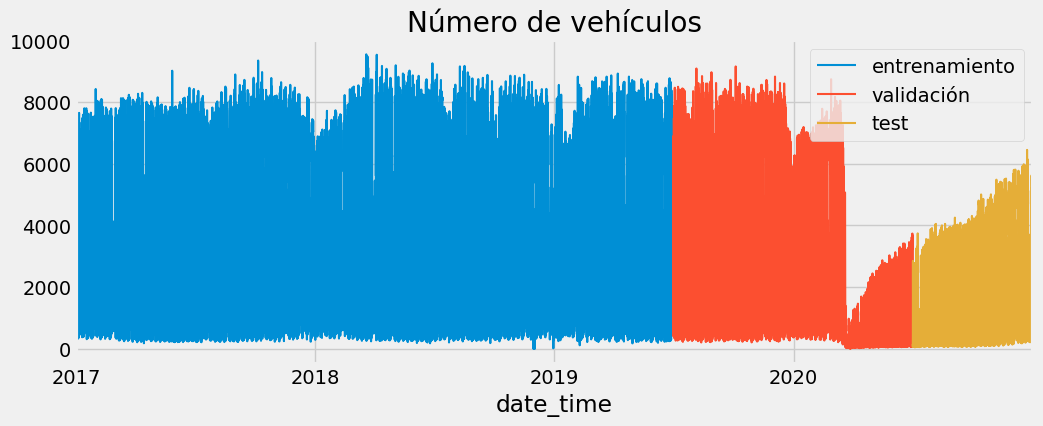

In [105]:
# Gráfico serie temporal
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
datos_train['traffic_count'].plot(ax=ax, label='entrenamiento')
datos_val['traffic_count'].plot(ax=ax, label='validación')
datos_test['traffic_count'].plot(ax=ax, label='test')
ax.set_title('Número de vehículos')
ax.legend();

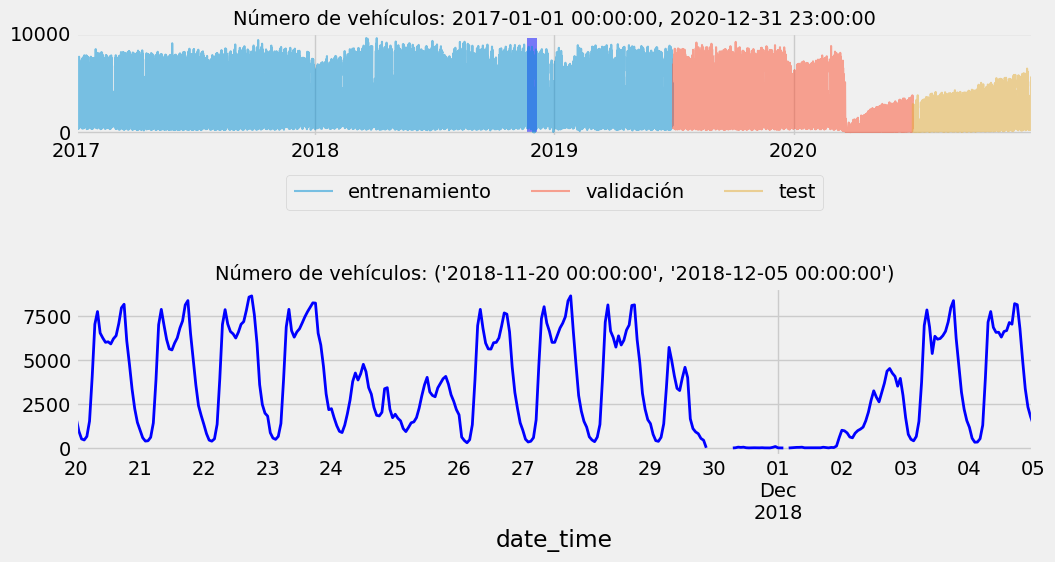

In [106]:
# Gráfico serie temporal con zoom
# ==============================================================================
zoom = ('2018-11-20 00:00:00','2018-12-05 00:00:00')

fig = plt.figure(figsize=(11, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

datos_train['traffic_count'].plot(ax=main_ax, label='entrenamiento', alpha=0.5)
datos_val['traffic_count'].plot(ax=main_ax, label='validación', alpha=0.5)
datos_test['traffic_count'].plot(ax=main_ax, label='test', alpha=0.5)
min_y = min(datos['traffic_count'])
max_y = max(datos['traffic_count'])
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')
main_ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.8))

datos.loc[zoom[0]: zoom[1]]['traffic_count'].plot(ax=zoom_ax, color='blue', linewidth=2)

main_ax.set_title(f'Número de vehículos: {datos.index.min()}, {datos.index.max()}', fontsize=14)
zoom_ax.set_title(f'Número de vehículos: {zoom}', fontsize=14)
plt.subplots_adjust(hspace=1)

In [107]:
# Gráfico interactivo serie temporal
# ==============================================================================
datos.loc[:fin_train, 'particion'] = 'entrenamiento'
datos.loc[fin_train:fin_validacion, 'particion'] = 'validación'
datos.loc[fin_validacion:, 'particion'] = 'test'

fig = px.line(
    data_frame = datos.reset_index(),
    x      = 'date_time',
    y      = 'traffic_count',
    color  = 'particion',
    title  = 'Número de vehículos',
    width  = 900,
    height = 500
)

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

datos=datos.drop(columns='particion')

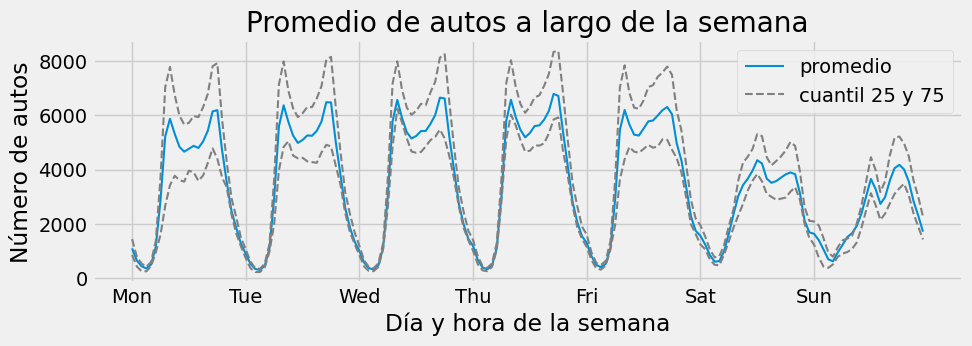

In [108]:
# Gráfico boxplot para estacionalidad diaria
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 3))
promedio_dia_hora = datos.groupby(["weekday", "hour"])["traffic_count"].mean()
q25_dia_hora = datos.groupby(["weekday", "hour"])["traffic_count"].quantile(0.25)
q75_dia_hora = datos.groupby(["weekday", "hour"])["traffic_count"].quantile(0.75)

promedio_dia_hora.plot(ax=ax, label='promedio')
q25_dia_hora.plot(ax=ax, linestyle='dashed', color='gray', label='')
q75_dia_hora.plot(ax=ax, linestyle='dashed', color='gray', label='cuantil 25 y 75')


ax.set(
    title="Promedio de autos a largo de la semana",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel="Día y hora de la semana",
    ylabel="Número de autos"
)

ax.legend();

## Gráficos de autocorrelación

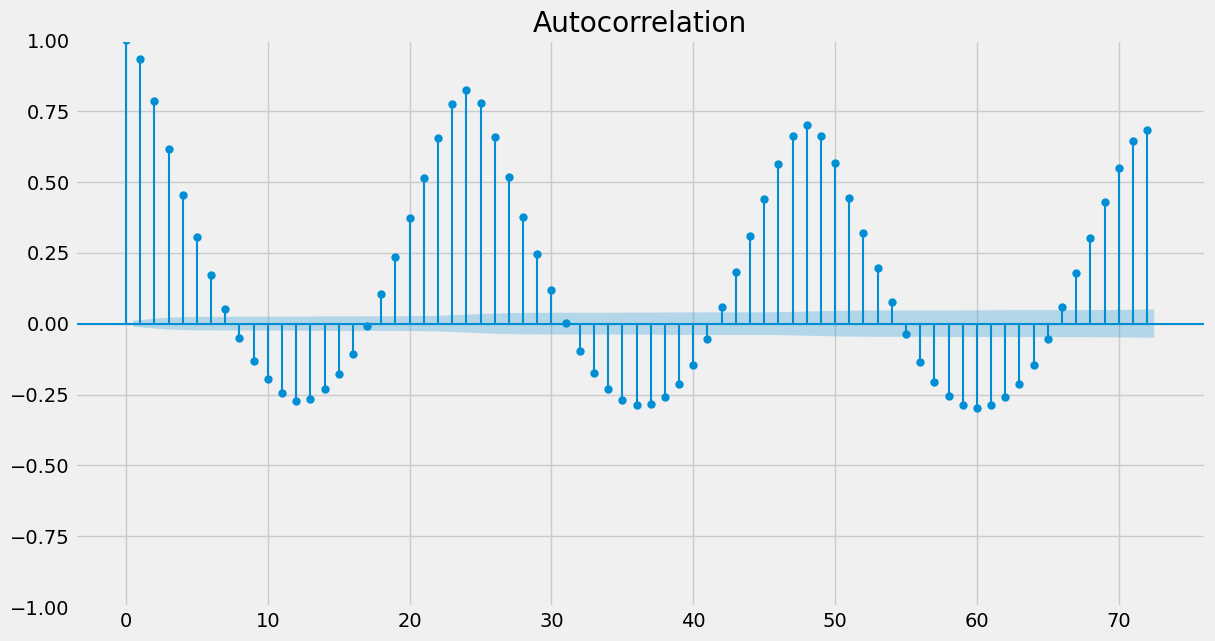

In [110]:
# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(13, 7))
plot_acf(
  datos['traffic_count'].fillna(
    datos.groupby([datos.index.hour])['traffic_count'].transform('mean')
  )  # Rellenar nulos hacia adelante
  , ax=ax
  , lags=72
  )
#plot_acf(data_a, lags=90)
plt.show()

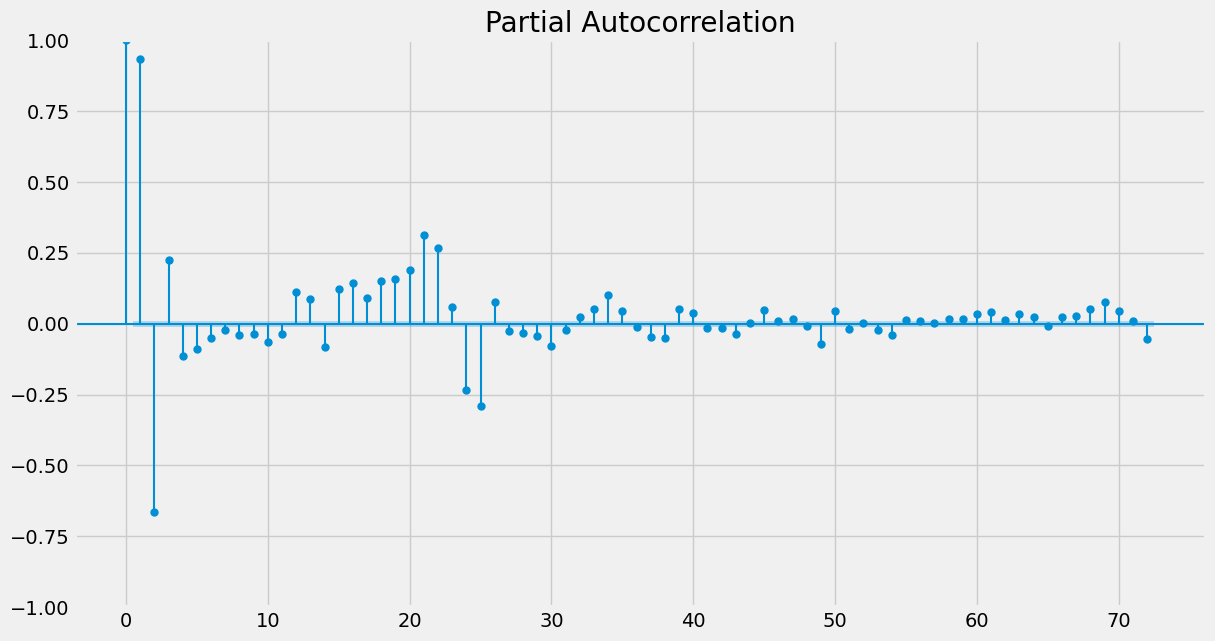

In [111]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, ax = plt.subplots(figsize=(13, 7))
plot_pacf(
  datos['traffic_count'].fillna(
    datos.groupby([datos.index.hour])['traffic_count'].transform('mean')
  ) 
  , ax=ax, lags=72
  , method='ywm'
)
plt.show()

## XGBoost
XGBoost, acrónimo de Extreme Gradient Boosting es una implementación muy eficiente del algoritmo de stochastic gradient boosting que se ha convertido en un referente dentro del ámbito de machine learning. Además de su propia API, la librería XGBoost incluye la clase XGBRegressor que sigue la API de scikit learn y, por lo tanto, es compatible con skforecast.

Como primera aproximación se utiliza un modelo autorregresivo que utiliza como predictores valores pasados (lags) de la propia variable respuesta. Dada la elevada cantidad de hiperparámetros que tienen los modelos de gradient boosting, se emplea una estrategia de gridsearch combinada con backtesting para identificar la configuración con la que se obtienen mejores predicciones.

In [112]:
# Crear forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 24
             )

forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogen

In [ ]:
# Grid search de hiperparámetros
# ==============================================================================
# Hiperparámetros del regresor
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}



# Rellenar valores nulos con el promedio por hora
datos.loc[:fin_validacion, 'traffic_count'] = datos.loc[:fin_validacion, 'traffic_count'].fillna(
    datos.loc[:fin_validacion, 'traffic_count'].groupby(datos.loc[:fin_validacion].index.hour).transform('mean')
)



Number of models compared: 36.


lags grid: 100%|██████████| 3/3 [03:26<00:00, 68.70s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 1595026.3208495907



In [ ]:
# Lags utilizados como predictores
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

# Grid search de hiperparámetros
resultados_grid = grid_search_forecaster(
        forecaster         = forecaster,
        y                  = datos.loc[:fin_validacion, 'traffic_count'], # conjunto de train y validación
        param_grid         = param_grid,
        lags_grid          = lags_grid,
        steps              = 36,
        refit              = False,
        metric             = 'mean_squared_error',
        initial_train_size = int(len(datos_train)), # El modelo se entrena con los datos de entrenamiento
        return_best        = True,
        verbose            = False
)

Number of models compared: 48.


lags grid: 100%|██████████| 4/4 [04:11<00:00, 62.83s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 1595026.3208495907



# Resultados Grid Search
# ==============================================================================
resultados_grid

## Backtesting periodo de test

In [118]:
len(datos.loc[:fin_validacion])

30648

In [119]:
# Backtesting
# ==============================================================================
metric, predicciones = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos['traffic_count'],
    initial_train_size = len(datos.loc[:fin_validacion]),
    steps      = 60,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False
)

print(f"Error de backtest: {metric}")

100%|██████████| 74/74 [00:01<00:00, 40.16it/s]

Error de backtest:    mean_squared_error
0        1.793159e+06


In [120]:
predicciones

pred
2020-07-01 00:00:00   198.893967
2020-07-01 01:00:00   183.783417
2020-07-01 02:00:00   197.332901
2020-07-01 03:00:00   215.595230
2020-07-01 04:00:00   291.404602
...                          ...
2020-12-31 19:00:00  4568.401855
2020-12-31 20:00:00  3420.754639
2020-12-31 21:00:00  2610.554932
2020-12-31 22:00:00  1852.870605
2020-12-31 23:00:00  1431.449707

[4416 rows x 1 columns]

In [78]:
# Save predicciones test
# ==============================================================================
def guardar_resultados(datos, modelo):
    fecha_ejecucion = datetime.now()
    resultados = pd.DataFrame({
        'DATE_TIME': datos.index,
        'PREDICCION': datos['pred'],
        'MODELO': modelo,
        'EXECUTION_DATE': fecha_ejecucion
    })
    return resultados

def upload_df_to_blob(df: pd.DataFrame, table_name: str, connection_str: str):
    try:
        df = df.where(pd.notnull(df), None)
        with pyodbc.connect(connection_str, autocommit=True) as conn:
            cursor = conn.cursor()
            columns = ','.join(df.columns)
            cmd_insert = f"INSERT INTO {table_name} ({columns}) VALUES ({','.join(['?'] * len(df.columns))})"
            cursor.fast_executemany = True
            cursor.executemany(cmd_insert, df.values.tolist())
        return True, ""
    except Exception as e:
        return False, str(e)

def guardar_pronostico(datos, modelo):
    # Obtener la fecha de ejecución actual
    fecha_ejecucion = datetime.now()
    
    # Crear un nuevo DataFrame con las columnas requeridas
    resultados = pd.DataFrame({
        'DATE_TIME': datos.index,        # Fecha (index)
        'PREDICCION': datos['pred'],       # Columna pred
        'MODELO': modelo            # Nombre del modelo
    })
    
    return resultados

In [124]:
# Save predicciones test
# ==============================================================================
rs1 = guardar_resultados(predicciones, 'MODEL_FORECASTER')
upload_df_to_blob(df = rs1, table_name = 'PREDICCION_TRAFFIC_FLOW', connection_str = cnn)

(True, '')

In [125]:
forecaster.fit(y=datos_train['traffic_count'])

In [126]:
data1 = forecaster.predict(steps=2160, last_window=datos['traffic_count'])
data1 = pd.DataFrame(data1)
data1

pred
2021-01-01 00:00:00   464.522827
2021-01-01 01:00:00   713.651184
2021-01-01 02:00:00   824.502319
2021-01-01 03:00:00  1110.163940
2021-01-01 04:00:00  1246.606445
...                          ...
2021-03-31 19:00:00   824.940308
2021-03-31 20:00:00   747.284180
2021-03-31 21:00:00   704.846619
2021-03-31 22:00:00   660.647217
2021-03-31 23:00:00   640.113220

[2160 rows x 1 columns]

In [128]:
# Save forecasting
# ==============================================================================
rs1 = guardar_pronostico(data1, 'MODEL_FORECASTER')
upload_df_to_blob(df = rs1, table_name = 'FORECASTING_TRAFFIC_FLOW', connection_str = cnn)

(True, '')

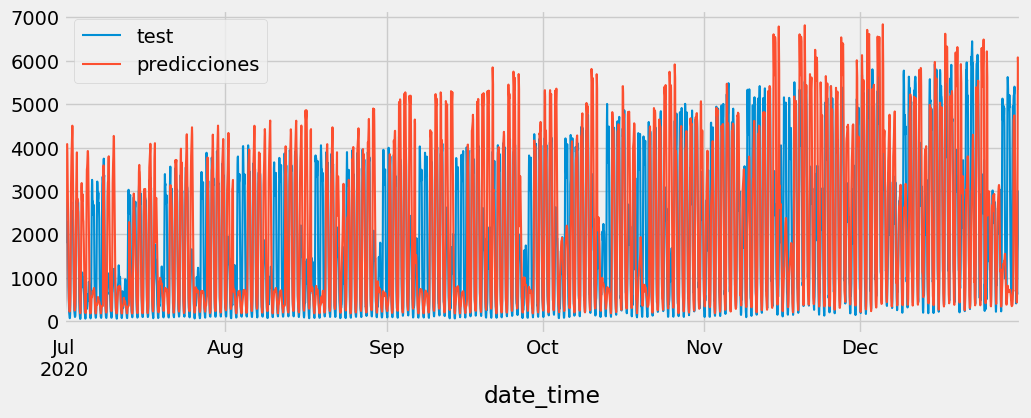

In [129]:
# Gráfico estatico predicciones test
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
datos_test['traffic_count'].plot(ax=ax, label='test')
predicciones['pred'].plot(ax=ax, label='predicciones')
ax.legend();

In [130]:
# Gráfico interactivo serie temporal
# ==============================================================================
datos_plot = pd.DataFrame({
                'test': datos_test['traffic_count'],
                'prediccion': predicciones['pred'],

                 })
datos_plot.index.name = 'date_time'

fig = px.line(
    data_frame = datos_plot.reset_index(),
    x      = 'date_time',
    y      = datos_plot.columns,
    title  = 'Número de autos: test vs predicciones',
    width  = 900,
    height = 500
)

fig.update_xaxes(rangeslider_visible=True)
fig.show()

## Incluir variables exógenas


In [57]:
# Query SQL para extraer datos
_, datos = get_blob_to_df(table_name = 'dbo.vw_FACT_TRAFFIC_FLOW_FORECASTING', connection_str = cnn)

In [ ]:
datos

date_time  hour period  month  weekday    sentido  \
0       2017-01-01 00:00:00     0     AM      1        6     Centro   
1       2017-01-01 00:00:00     0     AM      1        6     Centro   
2       2017-01-01 00:00:00     0     AM      1        6     Centro   
3       2017-01-01 00:00:00     0     AM      1        6     Centro   
4       2017-01-01 00:00:00     0     AM      1        6     Centro   
...                     ...   ...    ...    ...      ...        ...   
1048570 2020-12-29 10:00:00    10     AM     12        1  Provincia   
1048571 2020-12-29 11:00:00    11     AM     12        1     Centro   
1048572 2020-12-29 12:00:00    12     PM     12        1  Provincia   
1048573 2020-12-29 13:00:00    13     PM     12        1     Centro   
1048574 2020-12-29 15:00:00    15     PM     12        1     Centro   

          tipo_vehiculo  forma_pago  traffic_count  TIPO_CONJUNTO  
0               Liviano  no cobrado            252              1  
1               Liviano    efectivo              1              1  
2               Liviano    telepase            100              1  
3                Pesado    telepase              2              1  
4                Pesado    telepase              1              1  
...                 ...         ...            ...            ...  
1048570  Pesados 6 Ejes         tag              1              1  
1048571  Pesados 6 Ejes         tag              2              1  
1048572  Pesados 6 Ejes         tag              1              1  
1048573  Pesados 6 Ejes         tag              1              1  
1048574  Pesados 6 Ejes         tag              1              1  

[1048575 rows x 10 columns]

In [58]:
import numpy as np

# Crear columnas precomputadas de forma vectorizada
for sentido in datos['sentido'].unique():
    datos[f'Sentido_{sentido}'] = np.where(datos['sentido'] == sentido, datos['traffic_count'], 0)

for tipo_vehiculo in datos['tipo_vehiculo'].unique():
    datos[f'TV_{tipo_vehiculo}'] = np.where(datos['tipo_vehiculo'] == tipo_vehiculo, datos['traffic_count'], 0)

for forma_pago in datos['forma_pago'].unique():
    datos[f'Forma_Pago_{forma_pago}'] = np.where(datos['forma_pago'] == forma_pago, datos['traffic_count'], 0)

# Agrupar y sumar
datos_pivot = datos.groupby(['date_time', 'hour', 'weekday', 'month', 'period', 'TIPO_CONJUNTO']).sum()

In [59]:
# Drop columnas originales
datos_pivot = datos_pivot.drop(columns=['sentido', 'tipo_vehiculo', 'forma_pago'])

In [60]:
# Crear columnas de porcentajes de forma vectorizada
for col in [col for col in datos_pivot.columns if col.startswith('Sentido_') or col.startswith('TV_') or col.startswith('Forma_Pago_')]:
    datos_pivot[f'{col}_pct'] = datos_pivot[col] / datos_pivot['traffic_count']

In [61]:
datos_pivot = datos_pivot.reset_index()

In [63]:
datos_pivot

date_time  hour  weekday  month period  TIPO_CONJUNTO  \
0     2017-01-01 00:00:00     0        6      1     AM              1   
1     2017-01-01 01:00:00     1        6      1     AM              1   
2     2017-01-01 02:00:00     2        6      1     AM              1   
3     2017-01-01 03:00:00     3        6      1     AM              1   
4     2017-01-01 04:00:00     4        6      1     AM              1   
...                   ...   ...      ...    ...    ...            ...   
35048 2020-12-31 19:00:00    19        3     12     PM              1   
35049 2020-12-31 20:00:00    20        3     12     PM              1   
35050 2020-12-31 21:00:00    21        3     12     PM              1   
35051 2020-12-31 22:00:00    22        3     12     PM              1   
35052 2020-12-31 23:00:00    23        3     12     PM              1   

       traffic_count  Sentido_Centro  Sentido_Provincia  TV_Liviano  ...  \
0                598             356                242         594  ...   
1               2222            1271                951        2201  ...   
2               2632            1537               1095        2609  ...   
3               1780            1074                706        1760  ...   
4                794             442                352         780  ...   
...              ...             ...                ...         ...  ...   
35048           2602            1132               1470           0  ...   
35049           2830            1232               1598           0  ...   
35050           1865             893                972           0  ...   
35051            480             228                252           0  ...   
35052            243             130                113           0  ...   

       Forma_Pago_exento_pct  Forma_Pago_tarjeta discapacidad_pct  \
0                   0.000000                             0.000000   
1                   0.003150                             0.013951   
2                   0.001140                             0.009878   
3                   0.007303                             0.010112   
4                   0.007557                             0.008816   
...                      ...                                  ...   
35048               0.001153                             0.000000   
35049               0.003887                             0.000000   
35050               0.000000                             0.000000   
35051               0.000000                             0.000000   
35052               0.000000                             0.000000   

       Forma_Pago_infraccion_pct  Forma_Pago_monedero_pct  \
0                       0.000000                      0.0   
1                       0.002700                      0.0   
2                       0.002280                      0.0   
3                       0.001124                      0.0   
4                       0.002519                      0.0   
...                          ...                      ...   
35048                   0.000000                      0.0   
35049                   0.000000                      0.0   
35050                   0.000000                      0.0   
35051                   0.000000                      0.0   
35052                   0.000000                      0.0   

       Forma_Pago_rec.deuda_pct  Forma_Pago_tarjeta magnética_pct  \
0                      0.000000                          0.000000   
1                      0.000000                          0.000000   
2                      0.000000                          0.000000   
3                      0.000000                          0.000000   
4                      0.000000                          0.000000   
...                         ...                               ...   
35048                  0.004996                          0.003459   
35049                  0.003534                          0.001060   
35050                  0.000000            

In [64]:
# Index a datetime
datos_pivot['date_time'] = pd.to_datetime(datos_pivot['date_time'], format='%Y-%m-%d %H:%M:%S')

# Establecer 'date_time' como índice del DataFrame
datos_pivot = datos_pivot.set_index('date_time')

# Ajustar la frecuencia del DataFrame a intervalos horarios
datos_pivot = datos_pivot.asfreq('H')

# Ordenar el DataFrame por el índice (date_time)
datos_pivot = datos_pivot.sort_index()
# Mostrar el DataFrame resultante
datos_pivot

hour  weekday  month period  TIPO_CONJUNTO  \
date_time                                                         
2017-01-01 00:00:00   0.0      6.0    1.0     AM            1.0   
2017-01-01 01:00:00   1.0      6.0    1.0     AM            1.0   
2017-01-01 02:00:00   2.0      6.0    1.0     AM            1.0   
2017-01-01 03:00:00   3.0      6.0    1.0     AM            1.0   
2017-01-01 04:00:00   4.0      6.0    1.0     AM            1.0   
...                   ...      ...    ...    ...            ...   
2020-12-31 19:00:00  19.0      3.0   12.0     PM            1.0   
2020-12-31 20:00:00  20.0      3.0   12.0     PM            1.0   
2020-12-31 21:00:00  21.0      3.0   12.0     PM            1.0   
2020-12-31 22:00:00  22.0      3.0   12.0     PM            1.0   
2020-12-31 23:00:00  23.0      3.0   12.0     PM            1.0   

                     traffic_count  Sentido_Centro  Sentido_Provincia  \
date_time                                                               
2017-01-01 00:00:00          598.0           356.0              242.0   
2017-01-01 01:00:00         2222.0          1271.0              951.0   
2017-01-01 02:00:00         2632.0          1537.0             1095.0   
2017-01-01 03:00:00         1780.0          1074.0              706.0   
2017-01-01 04:00:00          794.0           442.0              352.0   
...                            ...             ...                ...   
2020-12-31 19:00:00         2602.0          1132.0             1470.0   
2020-12-31 20:00:00         2830.0          1232.0             1598.0   
2020-12-31 21:00:00         1865.0           893.0              972.0   
2020-12-31 22:00:00          480.0           228.0              252.0   
2020-12-31 23:00:00          243.0           130.0              113.0   

                     TV_Liviano  TV_Pesado  ...  Forma_Pago_exento_pct  \
date_time                                   ...                          
2017-01-01 00:00:00       594.0        4.0  ...               0.000000   
2017-01-01 01:00:00      2201.0       21.0  ...               0.003150   
2017-01-01 02:00:00      2609.0       23.0  ...               0.001140   
2017-01-01 03:00:00      1760.0       20.0  ...               0.007303   
2017-01-01 04:00:00       780.0       14.0  ...               0.007557   
...                         ...        ...  ...                    ...   
2020-12-31 19:00:00         0.0        0.0  ...               0.001153   
2020-12-31 20:00:00         0.0        0.0  ...               0.003887   
2020-12-31 21:00:00         0.0        0.0  ...               0.000000   
2020-12-31 22:00:00         0.0        0.0  ...               0.000000   
2020-12-31 23:00:00         0.0        0.0  ...               0.000000   

                     Forma_Pago_tarjeta discapacidad_pct  \
date_time                                                  
2017-01-01 00:00:00                             0.000000   
2017-01-01 01:00:00                             0.013951   
2017-01-01 02:00:00                             0.009878   
2017-01-01 03:00:00                             0.010112   
2017-01-01 04:00:00                             0.008816   
...                                                  ...   
2020-12-31 19:00:00                             0.000000   
2020-12-31 20:00:00                             0.000000   
2020-12-31 21:00:00                             0.000000   
2020-12-31 22:00:00                             0.000000   
2020-12-31 23:00:00                             0.000000   

                     Forma_Pago_infraccion_pct  Forma_Pago_monedero_pct  \
date_time                                                                 
2017-01-01 00:00:00                   0.000000                      0.0   
2017-01-01 01:00:00                   0.002700                      0.0   
2017-01-01 02:00:00                   0.002280                      0.0   
2017-01-01 03:00:00                   0.001124                      0.0   
2017-

In [66]:
datos_pivot['traffic_count'] = datos_pivot['traffic_count'].fillna(
    datos_pivot.groupby([datos_pivot.index.hour])['traffic_count'].transform('mean')
)

In [67]:
datos_pivot['weekday'] = datos_pivot['weekday'].fillna(
    datos_pivot.groupby([datos_pivot.index.hour])['weekday'].transform('mean')
)

In [68]:
datos_pivot['hour'] = datos_pivot['hour'].fillna(
    datos_pivot.groupby([datos_pivot.index.hour])['hour'].transform('mean')
)

In [69]:
datos = datos_pivot

In [70]:
# Cambio de las variables categóricas a tipo category
# ==============================================================================
datos['period'] = datos['period'].astype('category')
datos['month']   = datos['month'].astype('category')
datos['weekday'] = datos['weekday'].astype('category')

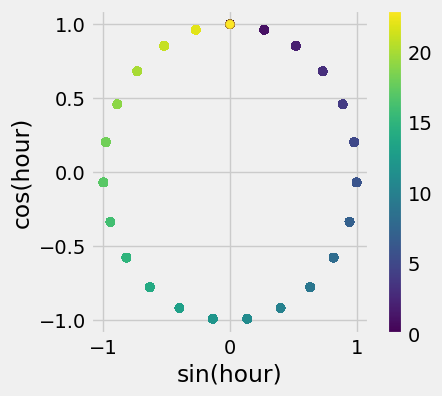

In [71]:
# Transformación seno-coseno de la variable hora
# ==============================================================================
datos['hour_sin'] = np.sin(datos['hour'] / 23 * 2 * np.pi)
datos['hour_cos'] = np.cos(datos['hour'] / 23 * 2 * np.pi)

# Representación de la transformación seno-coseno de la variable hora
# ==============================================================================
fig, ax = plt.subplots(figsize=(4, 4))
sp = ax.scatter(datos["hour_sin"], datos["hour_cos"], c=datos["hour"])
ax.set(
    xlabel="sin(hour)",
    ylabel="cos(hour)",
)
_ = fig.colorbar(sp)

datos = datos.drop(columns='hour')

In [72]:
# One hot encoding
# ==============================================================================
datos = pd.get_dummies(datos, columns=['period', 'month', 'weekday'])
datos.head(3)

TIPO_CONJUNTO  traffic_count  Sentido_Centro  \
date_time                                                           
2017-01-01 00:00:00            1.0          598.0           356.0   
2017-01-01 01:00:00            1.0         2222.0          1271.0   
2017-01-01 02:00:00            1.0         2632.0          1537.0   

                     Sentido_Provincia  TV_Liviano  TV_Pesado  TV_Auto  \
date_time                                                                
2017-01-01 00:00:00              242.0       594.0        4.0      0.0   
2017-01-01 01:00:00              951.0      2201.0       21.0      0.0   
2017-01-01 02:00:00             1095.0      2609.0       23.0      0.0   

                     TV_Auto con trailer  TV_Moto  TV_N/D  ...  weekday_1.0  \
date_time                                                  ...                
2017-01-01 00:00:00                  0.0      0.0     0.0  ...        False   
2017-01-01 01:00:00                  0.0      0.0     0.0  ...        False   
2017-01-01 02:00:00                  0.0      0.0     0.0  ...        False   

                     weekday_2.0  weekday_2.9958875942426317  \
date_time                                                      
2017-01-01 00:00:00        False                       False   
2017-01-01 01:00:00        False                       False   
2017-01-01 02:00:00        False                       False   

                     weekday_2.995890410958904  weekday_2.9972602739726026  \
date_time                                                                    
2017-01-01 00:00:00                      False                       False   
2017-01-01 01:00:00                      False                       False   
2017-01-01 02:00:00                      False                       False   

                     weekday_2.997945205479452  weekday_3.0  weekday_4.0  \
date_time                                                                  
2017-01-01 00:00:00                      False        False        False   
2017-01-01 01:00:00                      False        False        False   
2017-01-01 02:00:00                      False        False        False   

                     weekday_5.0  weekday_6.0  
date_time                                      
2017-01-01 00:00:00        False         True  
2017-01-01 01:00:00        False         True  
2017-01-01 02:00:00        False         True  

[3 rows x 87 columns]

In [ ]:
# Se seleccionan todas las variables exógenas, incluidas las obtenidas al hacer
# el one hot encoding.
variables_exogenas = [column for column in datos.columns
                      if column.startswith(('period', 'month', 'hour', 'weekday'))]
print(variables_exogenas)

['hour_sin', 'hour_cos', 'period_AM', 'period_PM', 'month_1.0', 'month_2.0', 'month_3.0', 'month_4.0', 'month_5.0', 'month_6.0', 'month_7.0', 'month_8.0', 'month_9.0', 'month_10.0', 'month_11.0', 'month_12.0', 'weekday_0.0', 'weekday_1.0', 'weekday_2.0', 'weekday_2.9958875942426317', 'weekday_2.995890410958904', 'weekday_2.9972602739726026', 'weekday_2.997945205479452', 'weekday_3.0', 'weekday_4.0', 'weekday_5.0', 'weekday_6.0']


In [74]:
# Como los datos han sido modificados, se repite el reparto en train, val y test.
fin_train = '2019-06-30 23:59:00'
fin_validacion = '2020-06-30 23:59:00'
datos_train = datos.loc[: fin_train, :]
datos_val   = datos.loc[fin_train:fin_validacion, :]
datos_test  = datos.loc[fin_validacion:, :]

print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train      : 2017-01-01 00:00:00 --- 2019-06-30 23:00:00  (n=21864)
Fechas validacion : 2019-07-01 00:00:00 --- 2020-06-30 23:00:00  (n=8784)
Fechas test       : 2020-07-01 00:00:00 --- 2020-12-31 23:00:00  (n=4416)


In [75]:
# Crear forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 24
             )

In [76]:
# Grid search de hiperparámetros
# ==============================================================================
# Hiperparámetros del regresor
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags utilizados como predictores
lags_grid = [72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos.loc[:fin_validacion, 'traffic_count'],
                        exog               = datos.loc[:fin_validacion, variables_exogenas],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 36,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)),
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 24.


lags grid: 100%|██████████| 2/2 [02:29<00:00, 74.89s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 1498588.4474351641



In [90]:
# Backtesting
# ==============================================================================
metric, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = datos['traffic_count'],
    exog               = datos[variables_exogenas],
    initial_train_size = len(datos.loc[:fin_validacion]),
    steps              = 36,
    refit              = False,
    metric             = 'mean_squared_error',
    verbose            = False
)

print(f"Error de backtest: {metric}")

100%|██████████| 123/123 [00:02<00:00, 56.42it/s]

Error de backtest:    mean_squared_error
0       996939.040791


In [79]:
predicciones

pred
2020-07-01 00:00:00   212.584183
2020-07-01 01:00:00   116.366089
2020-07-01 02:00:00    81.879150
2020-07-01 03:00:00    71.170914
2020-07-01 04:00:00   169.091171
...                          ...
2020-12-31 19:00:00  5100.970215
2020-12-31 20:00:00  3751.077637
2020-12-31 21:00:00  2616.370361
2020-12-31 22:00:00  1974.841309
2020-12-31 23:00:00  1313.151367

[4416 rows x 1 columns]

In [86]:
# Save predicciones test
# ==============================================================================
rs1 = guardar_resultados(predicciones, 'MODEL_EXOGENEAS')
upload_df_to_blob(df = rs1, table_name = 'PREDICCION_TRAFFIC_FLOW', connection_str = cnn)

(True, '')

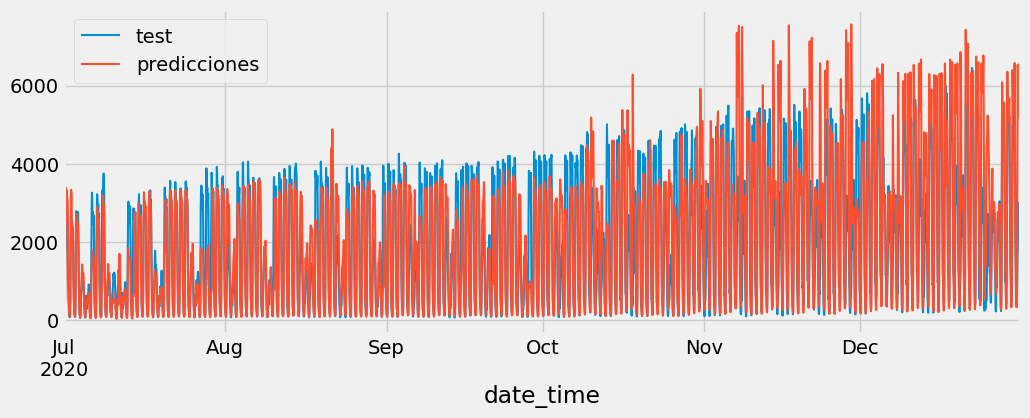

In [ ]:
# Gráfico estatico predicciones test
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
datos_test['traffic_count'].plot(ax=ax, label='test')
predicciones['pred'].plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
# Gráfico interactivo serie temporal
# ==============================================================================
datos_plot = pd.DataFrame({
                'test': datos_test['traffic_count'],
                'prediccion': predicciones['pred'],

                 })
datos_plot.index.name = 'date_time'

fig = px.line(
    data_frame = datos_plot.reset_index(),
    x      = 'date_time',
    y      = datos_plot.columns,
    title  = 'Número de autos: test vs predicciones',
    width  = 900,
    height = 500
)

fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [84]:
# Importancia predictores
# ==============================================================================
importancia = forecaster.regressor.get_booster().get_score(importance_type='weight')
importancia

{'lag_1': 5728.0,
 'lag_2': 2498.0,
 'lag_3': 1528.0,
 'lag_4': 1268.0,
 'lag_5': 1055.0,
 'lag_6': 883.0,
 'lag_7': 768.0,
 'lag_8': 790.0,
 'lag_9': 697.0,
 'lag_10': 648.0,
 'lag_11': 633.0,
 'lag_12': 614.0,
 'lag_13': 598.0,
 'lag_14': 502.0,
 'lag_15': 513.0,
 'lag_16': 511.0,
 'lag_17': 442.0,
 'lag_18': 445.0,
 'lag_19': 523.0,
 'lag_20': 487.0,
 'lag_21': 549.0,
 'lag_22': 482.0,
 'lag_23': 641.0,
 'lag_24': 778.0,
 'lag_25': 571.0,
 'lag_26': 511.0,
 'lag_27': 421.0,
 'lag_28': 405.0,
 'lag_29': 422.0,
 'lag_30': 402.0,
 'lag_31': 379.0,
 'lag_32': 376.0,
 'lag_33': 366.0,
 'lag_34': 330.0,
 'lag_35': 342.0,
 'lag_36': 331.0,
 'lag_37': 317.0,
 'lag_38': 289.0,
 'lag_39': 321.0,
 'lag_40': 341.0,
 'lag_41': 307.0,
 'lag_42': 317.0,
 'lag_43': 323.0,
 'lag_44': 352.0,
 'lag_45': 354.0,
 'lag_46': 348.0,
 'lag_47': 353.0,
 'lag_48': 418.0,
 'lag_49': 390.0,
 'lag_50': 387.0,
 'lag_51': 376.0,
 'lag_52': 339.0,
 'lag_53': 320.0,
 'lag_54': 369.0,
 'lag_55': 318.0,
 'lag_56': 357

In [93]:
last_window = datos['traffic_count'][-forecaster.window_size:]

# Asegurarse de que las variables exógenas estén alineadas temporalmente
exog_future = datos[variables_exogenas].iloc[-2160:]
exog_future.index = pd.date_range(
    start=last_window.index[-1] + pd.Timedelta(hours=1),  # Comienza justo después de last_window
    periods=2160,
    freq='H'  # Ajusta la frecuencia según tus datos (por ejemplo, 'H' para horas)
)

predicciones = forecaster.predict(
    steps=2160,
    last_window=last_window,
    exog=exog_future
)
predicciones = pd.DataFrame(predicciones)
predicciones

pred
2021-01-01 00:00:00   372.003296
2021-01-01 01:00:00  1444.942505
2021-01-01 02:00:00  1564.977783
2021-01-01 03:00:00  1506.792236
2021-01-01 04:00:00  1202.577515
...                          ...
2021-03-31 19:00:00  6935.454102
2021-03-31 20:00:00  5676.529785
2021-03-31 21:00:00  4059.371094
2021-03-31 22:00:00  2787.021973
2021-03-31 23:00:00  2286.060791

[2160 rows x 1 columns]

In [94]:
# Save forecasting
# ==============================================================================
rs1 = guardar_pronostico(predicciones, 'MODEL_EXOGENEAS')
upload_df_to_blob(df = rs1, table_name = 'FORECASTING_TRAFFIC_FLOW', connection_str = cnn)

(True, '')

## LightGBM

In [102]:
# Crear forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123, device='gpu'),
                lags = 24
             )

forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(device='gpu', random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'device': 'gpu'} 
fit_kwargs: {} 
Creation date: 2025-06-17 00:54:38 
Last fit date: None 
Skforecast version: 0.13.0 
Python versio

In [103]:
# Grid search de hiperparámetros
# ==============================================================================
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos.loc[:fin_validacion, 'traffic_count'],
                        exog               = datos.loc[:fin_validacion, variables_exogenas],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 36,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)),
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 48.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 6206
[LightGBM] [Info] Number of data points in the train set: 21840, number of used features: 47
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 6GB Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 29 dense feature groups (0.67 MB) transferred to GPU in 0.004471 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 3876.805411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 6206
[LightGBM] [Info] Number of data points in the train set: 21840, number of used features: 47
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 6GB Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 29 dense feature groups (0.67 MB) transferred to GPU in 0.003807 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 3876.805411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 6206
[LightGBM] [Info] Number of data points in the train set: 21840, number of used features: 47
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 6GB Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 29 dense feature groups (0.67 MB) transferred to GPU in 0.003680 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 3876.805411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 6206
[LightGBM] [Info] Number of data points in the train set: 21840, number of used features: 47
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 6GB Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 29 dense feature groups (0.67 MB) transferred to GPU in 0.004111 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 3876.805411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 6206
[LightGBM] [Info] Number of data points in the train set: 21840, number of used features: 47
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 6GB Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 29 dense feature groups (0.67 MB) transferred to GPU in 0.004298 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 3876.805411


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 6206
[LightGBM] [Info] Number of data points in the train set: 21840, number of used features: 47
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 6GB Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 29 dense feature groups (0.67 MB) transferred to GPU in 0.003981 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 3876.805411


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 6206
[LightGBM] [Info] Number of data points in the train set: 21840, number of used features: 47
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 6GB Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 29 dense feature groups (0.67 MB) transferred to GPU in 0.003765 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 3876.805411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 6206
[LightGBM] [Info] Number of data points in the train set: 21840, number of used features: 47
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 6GB Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 29 dense feature groups (0.67 MB) transferred to GPU in 0.003687 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 3876.805411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 6206
[LightGBM] [Info] Number of data points in the train set: 21840, number of used features: 47
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 6GB Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 29 dense feature groups (0.67 MB) transferred to GPU in 0.004051 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 3876.805411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 6206
[LightGBM] [Info] Number of data points in the train set: 21840, number of used features: 47
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 6GB Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 29 dense feature groups (0.67 MB) transferred to GPU in 0.003684 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 3876.805411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 6206
[LightGBM] [Info] Number of data points in the train set: 21840, number of used features: 47
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 6GB Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 29 dense feature groups (0.67 MB) transferred to GPU in 0.003479 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 3876.805411


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 6206
[LightGBM] [Info] Number of data points in the train set: 21840, number of used features: 47
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 6GB Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 29 dense feature groups (0.67 MB) transferred to GPU in 0.003887 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 3876.805411


lags grid:  25%|██▌       | 1/4 [01:45<05:17, 105.85s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12326
[LightGBM] [Info] Number of data points in the train set: 21816, number of used features: 71
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 6GB Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 53 dense feature groups (1.17 MB) transferred to GPU in 0.006596 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 3876.977502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

lags grid:  50%|█████     | 2/4 [03:29<03:29, 104.56s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 18446
[LightGBM] [Info] Number of data points in the train set: 21792, number of used features: 95
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 6GB Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 77 dense feature groups (1.66 MB) transferred to GPU in 0.007900 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 3876.997943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

lags grid:  75%|███████▌  | 3/4 [05:14<01:44, 104.95s/it]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2381
[LightGBM] [Info] Number of data points in the train set: 21791, number of used features: 32
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 6GB Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 14 dense feature groups (0.33 MB) transferred to GPU in 0.001794 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 3877.130888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

lags grid: 100%|██████████| 4/4 [06:49<00:00, 102.31s/it]


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12326
[LightGBM] [Info] Number of data points in the train set: 30600, number of used features: 71
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 6GB Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 53 dense feature groups (1.63 MB) transferred to GPU in 0.006615 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 3632.580365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

In [104]:
# Resultados Grid Search
# ==============================================================================
resultados_grid.head(10)

lags  \
18  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
37                  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
19  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
9   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
10  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
31  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
30  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
6   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
34  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
7   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                           lags_label  \
18  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
37                  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
19  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
9   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
10  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
31  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
30  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
6   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
34  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
7   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                               params  mean_squared_error  \
18  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...        1.460651e+06   
37  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...        1.583542e+06   
19  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...        1.597604e+06   
9   {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...        1.758830e+06   
10  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...        1.781539e+06   
31  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...        1.810700e+06   
30  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...        1.829332e+06   
6   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...        1.867609e+06   
34  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...        1.873222e+06   
7   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...        1.891917e+06   

    learning_rate  max_depth  n_estimators  
18           0.10        3.0         100.0  
37           0.01        3.0         500.0  
19           0.10        3.0         500.0  
9            0.10        5.0         500.0  
10           0.10       10.0         100.0  
31           0.10        3.0         500.0  
30           0.10        3.0         100.0  
6            0.10        3.0         100.0  
34           0.10       10.0         100.0  
7            0.10        3.0         500.0

In [105]:
# Backtesting
# ==============================================================================
metric, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = datos['traffic_count'],
    exog               = datos[variables_exogenas],
    initial_train_size = len(datos.loc[:fin_validacion]),
    steps              = 36,
    refit              = False,
    metric             = 'mean_squared_error',
    verbose            = False
)

print(f"Error de backtest: {metric}")

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12326
[LightGBM] [Info] Number of data points in the train set: 30600, number of used features: 71
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 6GB Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 53 dense feature groups (1.63 MB) transferred to GPU in 0.006794 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 3632.580365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

100%|██████████| 123/123 [00:03<00:00, 35.49it/s]

Error de backtest:    mean_squared_error
0        2.219318e+06


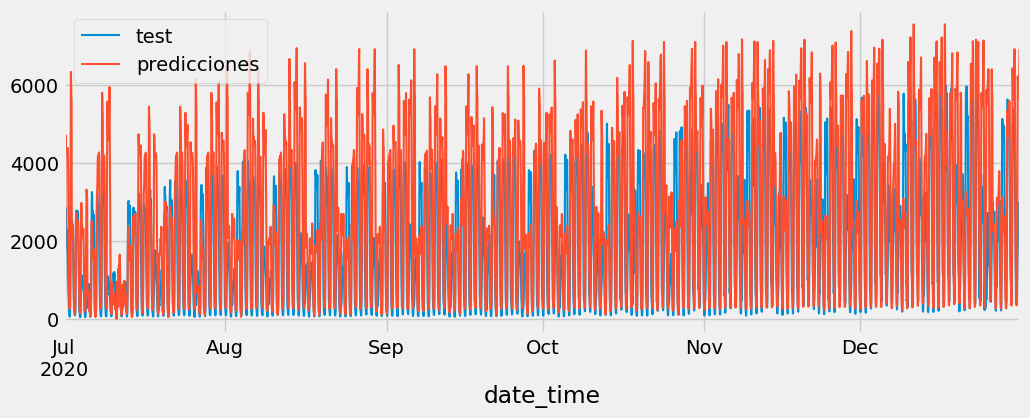

In [106]:
# Gráfico estatico predicciones test
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
datos_test['traffic_count'].plot(ax=ax, label='test')
predicciones['pred'].plot(ax=ax, label='predicciones')
ax.legend();

In [107]:
# Gráfico interactivo serie temporal
# ==============================================================================
datos_plot = pd.DataFrame({
                'test': datos_test['traffic_count'],
                'prediccion': predicciones['pred'],

                 })
datos_plot.index.name = 'date_time'

fig = px.line(
    data_frame = datos_plot.reset_index(),
    x      = 'date_time',
    y      = datos_plot.columns,
    title  = 'Número de autos: test vs predicciones',
    width  = 900,
    height = 500
)

fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [108]:
# Save predicciones test
# ==============================================================================
rs1 = guardar_resultados(predicciones, 'MODEL_EXOGENEAS_LGBM')
upload_df_to_blob(df = rs1, table_name = 'PREDICCION_TRAFFIC_FLOW', connection_str = cnn)

(True, '')

In [112]:
# Importancia predictores
# ==============================================================================
importancia = forecaster.regressor.feature_importances_
importancia

array([171,  28,  24,  32,  22,  11,   7,   7,   8,  11,  12,   7,  22,
         6,   4,   2,   0,   8,  17,   8,   3,   2,   9,  25,  14,   5,
         0,   1,   4,   6,   8,   4,   1,   9,   1,  13,   2,   3,   3,
         4,   3,   0,   4,   2,   6,   2,   6,   1,  63,  46,   0,   0,
         1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
         0,   0,   0,   0,   0,   0,   2,  17,   7,   2], dtype=int32)

In [114]:
last_window = datos['traffic_count'][-forecaster.window_size:]

# Asegurarse de que las variables exógenas estén alineadas temporalmente
exog_future = datos[variables_exogenas].iloc[-2160:]
exog_future.index = pd.date_range(
    start=last_window.index[-1] + pd.Timedelta(hours=1),  # Comienza justo después de last_window
    periods=2160,
    freq='H'  # Ajusta la frecuencia según tus datos (por ejemplo, 'H' para horas)
)

predicciones = forecaster.predict(
    steps=2160,
    last_window=last_window,
    exog=exog_future
)
predicciones = pd.DataFrame(predicciones)
predicciones

pred
2021-01-01 00:00:00   248.435237
2021-01-01 01:00:00   466.555539
2021-01-01 02:00:00   680.642905
2021-01-01 03:00:00  1073.147909
2021-01-01 04:00:00  1410.561976
...                          ...
2021-03-31 19:00:00  5858.170811
2021-03-31 20:00:00  4483.637407
2021-03-31 21:00:00  3150.422682
2021-03-31 22:00:00  2268.110480
2021-03-31 23:00:00  1690.614839

[2160 rows x 1 columns]

In [115]:
# Save forecasting
# ==============================================================================
rs1 = guardar_pronostico(predicciones, 'MODEL_EXOGENEAS_LGBM')
upload_df_to_blob(df = rs1, table_name = 'FORECASTING_TRAFFIC_FLOW', connection_str = cnn)

(True, '')

## CatBoost

In [116]:
# Crear forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = CatBoostRegressor(random_state=123, silent=True, task_type='GPU'),
                lags = 24
             )

forecaster

ForecasterAutoreg 
Regressor: <catboost.core.CatBoostRegressor object at 0x000001F19F80F340> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'loss_function': 'RMSE', 'silent': True, 'task_type': 'GPU', 'random_state': 123} 
fit_kwargs: {} 
Creation date: 2025-06-17 01:11:01 
Last fit date: None 
Skforecast version: 0.13.0 
Python version: 3.10.11 
Forecaster id: None 

In [117]:
# Grid search de hiperparámetros
# ==============================================================================
# Hiperparámetros del regresor
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags utilizados como predictores
lags_grid = [72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos.loc[:fin_validacion, 'traffic_count'],
                        exog               = datos.loc[:fin_validacion, variables_exogenas],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 36,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)),
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 24.


lags grid: 100%|██████████| 2/2 [06:05<00:00, 182.60s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 1678941.6103049247



In [118]:
# Resultados Grid Search
# ==============================================================================
resultados_grid.head(10)

lags  \
3   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
5   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
9   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
8   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
11  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
7   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
13                  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
10  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
6   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                           lags_label  \
3   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
5   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
9   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
8   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
11  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
7   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
13                  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
10  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
6   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                               params  mean_squared_error  \
3   {'learning_rate': 0.01, 'max_depth': 5, 'n_est...        1.678942e+06   
5   {'learning_rate': 0.01, 'max_depth': 10, 'n_es...        1.817603e+06   
9   {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...        1.927655e+06   
8   {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...        1.952818e+06   
11  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...        2.089723e+06   
1   {'learning_rate': 0.01, 'max_depth': 3, 'n_est...        2.137268e+06   
7   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...        2.159201e+06   
13  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...        2.323227e+06   
10  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...        2.324109e+06   
6   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...        2.344453e+06   

    learning_rate  max_depth  n_estimators  
3            0.01        5.0         500.0  
5            0.01       10.0         500.0  
9            0.10        5.0         500.0  
8            0.10        5.0         100.0  
11           0.10       10.0         500.0  
1            0.01        3.0         500.0  
7            0.10        3.0         500.0  
13           0.01        3.0         500.0  
10           0.10       10.0         100.0  
6            0.10        3.0         100.0

In [119]:
# Backtesting
# ==============================================================================
metric, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = datos['traffic_count'],
    exog               = datos[variables_exogenas],
    initial_train_size = len(datos.loc[:fin_validacion]),
    steps              = 36,
    refit              = False,
    metric             = 'mean_squared_error',
    verbose            = False
)

print(f"Error de backtest: {metric}")

100%|██████████| 123/123 [00:03<00:00, 38.05it/s]

Error de backtest:    mean_squared_error
0        1.967407e+06


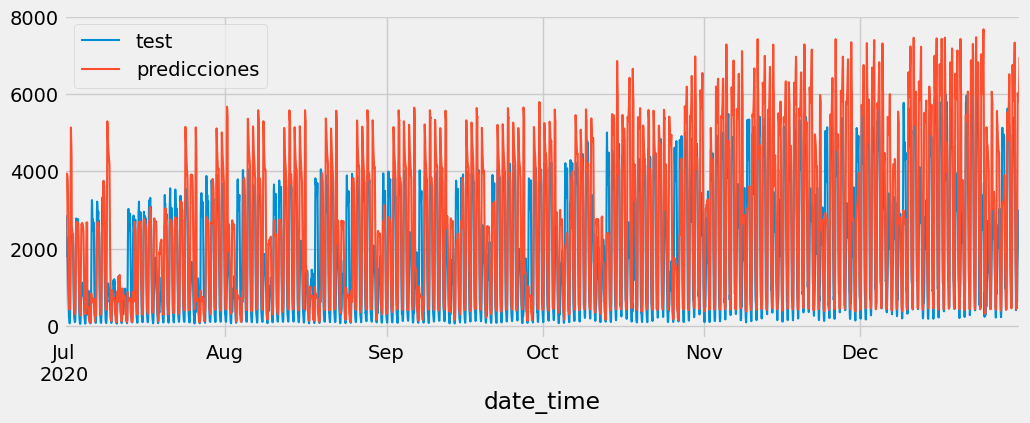

In [120]:
# Gráfico estatico predicciones test
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
datos_test['traffic_count'].plot(ax=ax, label='test')
predicciones['pred'].plot(ax=ax, label='predicciones')
ax.legend();

In [121]:
# Gráfico interactivo serie temporal
# ==============================================================================
datos_plot = pd.DataFrame({
                'test': datos_test['traffic_count'],
                'prediccion': predicciones['pred'],

                 })
datos_plot.index.name = 'date_time'

fig = px.line(
    data_frame = datos_plot.reset_index(),
    x      = 'date_time',
    y      = datos_plot.columns,
    title  = 'Número de autos: test vs predicciones',
    width  = 900,
    height = 500
)

fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [125]:
# Save predicciones test
# ==============================================================================
rs1 = guardar_resultados(predicciones, 'MODEL_EXOGENEAS_CatBoost')
upload_df_to_blob(df = rs1, table_name = 'PREDICCION_TRAFFIC_FLOW', connection_str = cnn)

(True, '')

In [127]:
last_window = datos['traffic_count'][-forecaster.window_size:]

# Asegurarse de que las variables exógenas estén alineadas temporalmente
exog_future = datos[variables_exogenas].iloc[-2160:]
exog_future.index = pd.date_range(
    start=last_window.index[-1] + pd.Timedelta(hours=1),  # Comienza justo después de last_window
    periods=2160,
    freq='H'  # Ajusta la frecuencia según tus datos (por ejemplo, 'H' para horas)
)

predicciones = forecaster.predict(
    steps=2160,
    last_window=last_window,
    exog=exog_future
)
predicciones = pd.DataFrame(predicciones)
predicciones

pred
2021-01-01 00:00:00   476.341918
2021-01-01 01:00:00   389.954490
2021-01-01 02:00:00   301.137868
2021-01-01 03:00:00   328.530836
2021-01-01 04:00:00   427.159094
...                          ...
2021-03-31 19:00:00  6363.911161
2021-03-31 20:00:00  5009.110322
2021-03-31 21:00:00  3627.445506
2021-03-31 22:00:00  2786.542235
2021-03-31 23:00:00  1896.903330

[2160 rows x 1 columns]

In [128]:
# Save forecasting
# ==============================================================================
rs1 = guardar_pronostico(predicciones, 'MODEL_EXOGENEAS_CatBoost')
upload_df_to_blob(df = rs1, table_name = 'FORECASTING_TRAFFIC_FLOW', connection_str = cnn)

(True, '')

## LSTM

In [129]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [130]:
# Convertir los datos a numpy array
train_data = datos_train['traffic_count'].values.reshape(-1, 1)
val_data = datos_val['traffic_count'].values.reshape(-1, 1)
test_data = datos_test['traffic_count'].values.reshape(-1, 1)

# Escalar los datos entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)

In [131]:
# Función para crear secuencias temporales
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Definir el número de pasos temporales
time_steps = 24

In [132]:
# Crear secuencias temporales para entrenamiento, validación y prueba
X_train, y_train = create_sequences(train_data_scaled, time_steps)
X_val, y_val = create_sequences(val_data_scaled, time_steps)
X_test, y_test = create_sequences(test_data_scaled, time_steps)

# Reshape de los datos para que sean aceptados por la red LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [133]:
# Definir el modelo LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
683/683 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0379 - val_loss: 0.0038
Epoch 2/50
683/683 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 3/50
683/683 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 4/50
683/683 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 5/50
683/683 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 6/50
683/683 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 7/50
683/683 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 8/50
683/683 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 9/50
683/683 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 10/50
683/683 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 11/50
683/683 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 12/50
683/683 ━━━━━━━━━━━━━━━━━━━━ 7s 1

In [134]:
# Evaluar el modelo en el conjunto de prueba
loss = model.evaluate(X_test, y_test)
print("Loss en el conjunto de prueba:", loss)

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Loss en el conjunto de prueba: 0.0018826955929398537


In [135]:
# Predecir en el conjunto de prueba
predictions = model.predict(X_test)

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [136]:
# Desescalar las predicciones
predictions_descaled = scaler.inverse_transform(predictions)

# Mostrar algunas predicciones
for i in range(5):
    print("Predicción:", predictions_descaled[i][0])

Predicción: -156.09914
Predicción: 70.83129
Predicción: 316.50797
Predicción: 271.88632
Predicción: 254.22578


In [137]:
# Crear un DataFrame con las fechas y las predicciones del modelo LSTM
predicciones_df = pd.DataFrame(index=datos_test.index[time_steps:], columns=['pred'])
predicciones_df['pred'] = predictions_descaled
predicciones_df

pred
date_time                       
2020-07-02 00:00:00  -156.099136
2020-07-02 01:00:00    70.831291
2020-07-02 02:00:00   316.507965
2020-07-02 03:00:00   271.886322
2020-07-02 04:00:00   254.225784
...                          ...
2020-12-31 19:00:00  2725.290771
2020-12-31 20:00:00  2782.426514
2020-12-31 21:00:00  2550.799072
2020-12-31 22:00:00  1206.981445
2020-12-31 23:00:00   279.307953

[4392 rows x 1 columns]

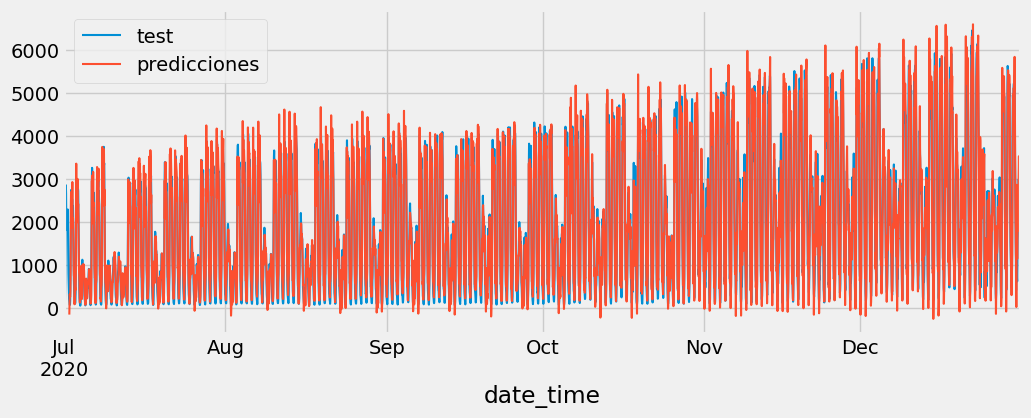

In [138]:
# Gráfico estatico predicciones test
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
datos_test['traffic_count'].plot(ax=ax, label='test')
predicciones_df['pred'].plot(ax=ax, label='predicciones')
ax.legend();

In [139]:
# Gráfico interactivo serie temporal
# ==============================================================================
datos_plot = pd.DataFrame({
                'test': datos_test['traffic_count'],
                'prediccion': predicciones_df['pred'],

                 })
datos_plot.index.name = 'date_time'

fig = px.line(
    data_frame = datos_plot.reset_index(),
    x      = 'date_time',
    y      = datos_plot.columns,
    title  = 'Número de autos: test vs predicciones',
    width  = 900,
    height = 500
)

fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [140]:
# Save predicciones test
# ==============================================================================
rs1 = guardar_resultados(predicciones_df, 'MODEL_EXOGENEAS_LSTM')
upload_df_to_blob(df = rs1, table_name = 'PREDICCION_TRAFFIC_FLOW', connection_str = cnn)

(True, '')

In [141]:
from datetime import timedelta
# Crear un rango de fechas futuro
start_date = pd.to_datetime('2021-01-01 00:00:00')
future_dates = [start_date + timedelta(hours=i) for i in range(90 * 24)]

# Utilizar los últimos datos conocidos para iniciar las predicciones
last_known_data = test_data_scaled[-time_steps:]

# Almacenar predicciones
future_predictions = []

for i in range(len(future_dates)):
    # Preparar el input para el modelo LSTM
    input_data = last_known_data.reshape((1, time_steps, 1))
    
    # Realizar la predicción
    prediction = model.predict(input_data)
    
    # Desescalar la predicción
    prediction_descaled = scaler.inverse_transform(prediction)
    
    # Almacenar la predicción
    future_predictions.append(prediction_descaled[0, 0])
    
    # Actualizar last_known_data para incluir la nueva predicción
    last_known_data = np.append(last_known_data[1:], prediction, axis=0)

# Crear un DataFrame con las fechas y las predicciones
future_predictions_df = pd.DataFrame(data=future_predictions, index=future_dates, columns=['pred'])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

In [142]:
# Mostrar las primeras predicciones futuras
future_predictions_df

pred
2021-01-01 00:00:00   490.791870
2021-01-01 01:00:00  1244.584351
2021-01-01 02:00:00  2042.080200
2021-01-01 03:00:00  3818.382812
2021-01-01 04:00:00  5981.719727
...                          ...
2021-03-31 19:00:00  7395.326660
2021-03-31 20:00:00  7439.342285
2021-03-31 21:00:00  5912.208496
2021-03-31 22:00:00  4535.854980
2021-03-31 23:00:00  3102.979492

[2160 rows x 1 columns]

In [143]:
# Save forecasting
# ==============================================================================
rs1 = guardar_pronostico(future_predictions_df, 'MODEL_EXOGENEAS_LSTM')
upload_df_to_blob(df = rs1, table_name = 'FORECASTING_TRAFFIC_FLOW', connection_str = cnn)

(True, '')

# recomendación
**truncar las tablas**
* PREDICCION_BIKE_SHARING
* FORECASTING_BIKE_SHARING